# Anticipate the electricity consumption needs of buildings

Based on the data hosted by the City of Seattle and providing information on non-residential buildings, we will design an application that predicts CO2 emissions and total energy consumption of buildings based on their characteristics. 

The construction stages of our application are:

1. Data mining
    - Merge databases
    - Univariate analysis
    - Multivariate analysis


2. Modeling
    - Modeling
    - Choose the best model

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.dummy import DummyRegressor
from sklearn.linear_model import LinearRegression, Lasso, Ridge, ElasticNet
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.model_selection import cross_val_score, GridSearchCV
from sklearn.compose import make_column_selector, make_column_transformer
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.feature_extraction import DictVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.impute import SimpleImputer
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor
from sklearn.ensemble import StackingRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.feature_selection import f_regression
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_selection import mutual_info_regression
from sklearn.metrics import r2_score, mean_squared_error
import pingouin as pg
import re 

# Load two datasets of two consecutive years

In [2]:
#load datasets

def load_datasets(path1, path2):
    #load datasets as a pandas DataFrame
    dt1 = pd.read_csv(path1, index_col = ['OSEBuildingID'])
    dt2 = pd.read_csv(path2, index_col = ['OSEBuildingID'])
    return dt1, dt2

In [3]:
path1 = 'D:/IML/project3/DATA/2015-building-energy-benchmarking.csv'
path2 = 'D:/IML/project3/DATA/2016-building-energy-benchmarking.csv'
dt1, dt2 = load_datasets(path1, path2)

In [4]:
# Correct mismatched features' names
dt1.rename({'GHGEmissions(MetricTonsCO2e)': 'TotalGHGEmissions',
                 'GHGEmissionsIntensity(kgCO2e/ft2)': 'GHGEmissionsIntensity'}, axis=1, inplace=True)

# Select imports features for the application

In [5]:
# select features and observations

def select_FO(data, features):
    #Select relevant features
    data = data[features]
    return data

In [6]:
features = ['BuildingType', 'PrimaryPropertyType', 'CouncilDistrictCode', 'Neighborhood', 'YearBuilt', 
            'NumberofFloors',  'PropertyGFATotal',  'PropertyGFABuilding(s)', 'PropertyGFAParking',
            'ListOfAllPropertyUseTypes', 'LargestPropertyUseTypeGFA', 'SecondLargestPropertyUseTypeGFA',
            'ThirdLargestPropertyUseTypeGFA', 'ENERGYSTARScore','SiteEUI(kBtu/sf)', 
            'SiteEUIWN(kBtu/sf)', 'SourceEUI(kBtu/sf)', 'SourceEUIWN(kBtu/sf)', 'SiteEnergyUse(kBtu)', 'SiteEnergyUseWN(kBtu)',
            'SteamUse(kBtu)', 'Electricity(kWh)', 'Electricity(kBtu)', 'NaturalGas(therms)', 'NaturalGas(kBtu)', 
            'GHGEmissionsIntensity','TotalGHGEmissions']

In [7]:
data_1 = select_FO(data = dt1, features = features)
data_2 = select_FO(data = dt2, features = features)

# Merge the datasets

In [8]:
# Merge datasets

def mergedt(data1, data2):
    data = data1.merge(data2, left_index=True, right_index=True,how="outer", suffixes=("_1", "_2")).sort_index(axis=1)
    return data

In [9]:
data = mergedt(data_1, data_2)
numerical_features = make_column_selector(dtype_include='float64')
#Some numeric features have negative values so we take the absolute value of all the numeric features
data[numerical_features] = np.abs(data[numerical_features])

# Split the dataset into training and testing

In [10]:
# split dataset into training and testing datasets

def splitdt(data, target, test_size=0.20, random_state=40):
    data_test = data.sample(frac = test_size, random_state = random_state)
    data_train = data.drop(data_test.index)
    target1 = target + '_1'
    target2 = target + '_2'
    X_train = data_train.drop([target1, target2], axis = 1)
    X_test = data_test.drop([target1, target2], axis = 1)
    y_train = data_train[[target1, target2]]
    y_test = data_test[[target1, target2]]
    return X_train, X_test, y_train, y_test

In [11]:
X_trainCO2, X_testCO2, y_trainCO2, y_testCO2 = splitdt(data, target= 'TotalGHGEmissions', test_size=0.20, random_state=40)
X_trainCTE, X_testCTE, y_trainCTE, y_testCTE = splitdt(data, target= 'SiteEnergyUse(kBtu)', test_size=0.20, random_state=50)

# Numerical and categorical features preprocessing

In [12]:
var = ['CouncilDistrictCode', 'ENERGYSTARScore', 'NumberofFloors', 'YearBuilt']
NumFeatures = data_1.select_dtypes(np.number).columns
QFeaturesCO2 = [elem for elem in NumFeatures if elem not in var]
QFeaturesCO2.remove('TotalGHGEmissions')
QFeaturesCTE = [elem for elem in NumFeatures if elem not in var]
QFeaturesCTE.remove('SiteEnergyUse(kBtu)')

QFeaturesCO2_1 = [elem + '_1' for elem in QFeaturesCO2]
QFeaturesCO2_2 = [elem + '_2' for elem in QFeaturesCO2]

QFeaturesCTE_1 = [elem + '_1' for elem in QFeaturesCTE]
QFeaturesCTE_2 = [elem + '_2' for elem in QFeaturesCTE]

In [13]:
# Data preprocessing
# Numerical missing data imputation
def NVmissingdata(data, Qfeat_1, Qfeat_2):
    QFeatures = zip(Qfeat_1, Qfeat_2)
    for QFeat in QFeatures:
        data.loc[data[QFeat[0]] < 0, QFeat[0]] = np.abs(data[data[QFeat[0]] < 0][QFeat[0]])
        data.loc[data[QFeat[1]] < 0, QFeat[1]] = np.abs(data[data[QFeat[1]] < 0][QFeat[1]])
        if any(data[QFeat[1]].isna()):
            dataset = data[[QFeat[0], QFeat[1]]].dropna()
            X_1 = dataset[[QFeat[0]]].values
            y_2 = dataset[QFeat[1]].values
            model = LinearRegression()
            model.fit(X_1, y_2)
            data.loc[(data[QFeat[1]].isna()) & 
                     (~data[QFeat[0]].isna()), QFeat[1]] = model.predict(data[(data[QFeat[1]].isna()) & 
                                                                                      (~data[QFeat[0]].isna())][[QFeat[0]]])
        if any(data[QFeat[0]].isna()):
            dataset = data[[QFeat[0], QFeat[1]]].dropna()
            X_2 = dataset[[QFeat[1]]].values
            y_1 = dataset[QFeat[0]].values
            model2 = LinearRegression()
            model2.fit(X_2, y_1)
            data.loc[(data[QFeat[0]].isna()) & 
                     (~data[QFeat[1]].isna()), QFeat[0]] = model.predict(data[(data[QFeat[0]].isna()) & 
                                                                                      (~data[QFeat[1]].isna())][[QFeat[1]]])
        return data
    
# Categorical variables preprocessing
def CatVarPr(data):
    # Fill BuildingType NaN  
    data['BuildingType_1'] = data['BuildingType_1'].fillna('BuildingTypeNA')
    data['BuildingType_2'] = data['BuildingType_2'].fillna('BuildingTypeNA')
    # We assume that CouncilDistrictCode feature remains the same in the time.
    data.loc[data['CouncilDistrictCode_1'].isna(), 'CouncilDistrictCode_1'] = data.loc[data['CouncilDistrictCode_1'].isna(), 'CouncilDistrictCode_2'] 
    data.loc[data['CouncilDistrictCode_2'].isna(), 'CouncilDistrictCode_2'] = data.loc[data['CouncilDistrictCode_2'].isna(), 'CouncilDistrictCode_1'] 
    # Let's create a variable giving us the Number of all Property Use Types
    data['NumberOfAllPropertyUseTypes_1'] = data['ListOfAllPropertyUseTypes_1'].str.count(',')+1
    data['NumberOfAllPropertyUseTypes_2'] = data['ListOfAllPropertyUseTypes_2'].str.count(',')+1
    data.drop(['ListOfAllPropertyUseTypes_1', 'ListOfAllPropertyUseTypes_2'], axis = 1, inplace = True)
    # We will assume that missing value in the NumberOfAllPropertyUseTypes feature means that the building in unused. 
    data['NumberOfAllPropertyUseTypes_1'] = data['NumberOfAllPropertyUseTypes_1'].fillna(0)
    data['NumberOfAllPropertyUseTypes_2'] = data['NumberOfAllPropertyUseTypes_2'].fillna(0)
    # We also assume that Neighborhood feature remains the same in the time.
    data['Neighborhood_1'] = data['Neighborhood_1'].str.upper()
    data['Neighborhood_2'] = data['Neighborhood_2'].str.upper()
    data.loc[data['Neighborhood_1'].isna(), 'Neighborhood_1'] = data.loc[data['Neighborhood_1'].isna(), 'Neighborhood_2']
    data.loc[data['Neighborhood_2'].isna(), 'Neighborhood_2'] = data.loc[data['Neighborhood_2'].isna(), 'Neighborhood_1']
    #Remove new line character from PrimaryPropertyType feature
    data['PrimaryPropertyType_1'] = data['PrimaryPropertyType_1'].replace('\n', '', regex=True)
    data['PrimaryPropertyType_2'] = data['PrimaryPropertyType_2'].replace('\n', '', regex=True)
    return data

In [14]:
X_trainCO2 = CatVarPr(NVmissingdata(data = X_trainCO2, Qfeat_1 = QFeaturesCO2_1, Qfeat_2 = QFeaturesCO2_2))
X_testCO2 = CatVarPr(NVmissingdata(data = X_testCO2, Qfeat_1 = QFeaturesCO2_1, Qfeat_2 = QFeaturesCO2_2))

In [15]:
X_trainCTE = CatVarPr(NVmissingdata(data = X_trainCTE, Qfeat_1 = QFeaturesCTE_1, Qfeat_2 = QFeaturesCTE_2))
X_testCTE = CatVarPr(NVmissingdata(data = X_testCTE, Qfeat_1 = QFeaturesCTE_1, Qfeat_2 = QFeaturesCTE_2))

In [16]:
VarNotToImpute = ['LargestPropertyUseTypeGFA_2015', 'LargestPropertyUseTypeGFA_2016', 
                  'SecondLargestPropertyUseTypeGFA_2015', 'SecondLargestPropertyUseTypeGFA_2016',
                  'ThirdLargestPropertyUseTypeGFA_2015', 'ThirdLargestPropertyUseTypeGFA_2016',
                  'PropertyGFATotal_2015', 'PropertyGFATotal_2016', 'PropertyGFAParking_2015', 
                  'PropertyGFAParking_2015','PropertyGFABuilding(s)_2015', 'PropertyGFABuilding(s)_2015']
numerical_features = QFeaturesCO2_1 + QFeaturesCO2_2 + ['NumberofFloors_1', 'YearBuilt_1', 'NumberofFloors_2', 'YearBuilt_2']
VarToImpute = [var for var in numerical_features if var not in VarNotToImpute]
imputer = SimpleImputer(strategy='median')

X_trainCO2[VarToImpute] = imputer.fit_transform(X_trainCO2[VarToImpute])
X_testCO2[VarToImpute] = imputer.fit_transform(X_testCO2[VarToImpute])

In [17]:
VarNotToImpute = ['LargestPropertyUseTypeGFA_2015', 'LargestPropertyUseTypeGFA_2016', 
                  'SecondLargestPropertyUseTypeGFA_2015', 'SecondLargestPropertyUseTypeGFA_2016',
                  'ThirdLargestPropertyUseTypeGFA_2015', 'ThirdLargestPropertyUseTypeGFA_2016',
                  'PropertyGFATotal_2015', 'PropertyGFATotal_2016', 'PropertyGFAParking_2015', 
                  'PropertyGFAParking_2015','PropertyGFABuilding(s)_2015', 'PropertyGFABuilding(s)_2015']
numerical_features = QFeaturesCTE_1 + QFeaturesCTE_2 + ['NumberofFloors_1', 'YearBuilt_1', 'NumberofFloors_2', 'YearBuilt_2']
VarToImpute = [var for var in numerical_features if var not in VarNotToImpute]
imputer = SimpleImputer(strategy='median')

X_trainCTE[VarToImpute] = imputer.fit_transform(X_trainCTE[VarToImpute])
X_testCTE[VarToImpute] = imputer.fit_transform(X_testCTE[VarToImpute])

# Log transformation of some numerical features

In [18]:
#Log1p Transformation
def log1pTranf(data):
    var = ['CouncilDistrictCode_1', 'ENERGYSTARScore_1', 'NumberofFloors_1', 'YearBuilt_1', 'NumberOfAllPropertyUseTypes_1',
          'CouncilDistrictCode_2', 'ENERGYSTARScore_2', 'NumberofFloors_2', 'YearBuilt_2', 'NumberOfAllPropertyUseTypes_2']
    NumFeatures = data.select_dtypes(np.number)
    QFeatures = [elem for elem in NumFeatures if elem not in var]
    LogQFeatures = ['Log' + elem for elem in NumFeatures if elem not in var]
    data[LogQFeatures] = np.log1p(data[QFeatures])
    data.drop(QFeatures, axis = 1, inplace = True)
    return data

In [19]:
for data in (X_trainCO2, X_trainCTE, X_testCO2, X_testCTE):
    log1pTranf(data)

# Categorize some features to capture the NaN's effects

In [20]:
#Categorize variables

def categVar(data, var, bins, group_names):
    VarNew = 'Cat' + var
    data[VarNew] = pd.cut(data[var], bins, labels=group_names)
    data.drop(var, axis = 1, inplace = True)
    data[VarNew] = data[VarNew].cat.add_categories('None') 
    data[VarNew] = data[VarNew].fillna('None') 
    return data

In [21]:
#LogLargestLogPropertyUseTypeGFA
bins = [0, 9.9, 10.3, 10.9, 17]
group_names = ['G1','G2','G3','G4']
for elem in ('LogLargestPropertyUseTypeGFA_1', 'LogLargestPropertyUseTypeGFA_2'):
    for data in (X_trainCO2, X_trainCTE, X_testCO2, X_testCTE):
        categVar(data, elem, bins, group_names)
        
#LogSecondLargestPropertyUseTypeGFA
bins = [0, 0.3, 8.5, 9.6, 14]
group_names = ['G1','G2','G3','G4']
for elem in ('LogSecondLargestPropertyUseTypeGFA_1', 'LogSecondLargestPropertyUseTypeGFA_2'):
    for data in (X_trainCO2, X_trainCTE, X_testCO2, X_testCTE):
        categVar(data, elem, bins, group_names)
        
#LogThirdLargestPropertyUseTypeGFA
bins = [0, 0.3, 7.8, 9.36, 14]
group_names = ['G1','G2','G3','G4']
for elem in ('LogThirdLargestPropertyUseTypeGFA_1', 'LogThirdLargestPropertyUseTypeGFA_2'):
    for data in (X_trainCO2, X_trainCTE, X_testCO2, X_testCTE):
        categVar(data, elem, bins, group_names)

#LogPropertyGFATotal
bins = [0, 10.36, 11, 17]
group_names = ['G1','G2','G3']
for elem in ('LogPropertyGFATotal_1', 'LogPropertyGFATotal_2'):
    for data in (X_trainCO2, X_trainCTE, X_testCO2, X_testCTE):
        categVar(data, elem, bins, group_names)

#LogPropertyGFAParking
bins = [0, 1.4, 14]
group_names = ['G1','G2']
for elem in ('LogPropertyGFAParking_1', 'LogPropertyGFAParking_2'):
    for data in (X_trainCO2, X_trainCTE, X_testCO2, X_testCTE):
        categVar(data, elem, bins, group_names)        

#LogPropertyGFABuilding(s)
bins = [0, 9.9, 10.2, 11, 12.1, 16]
group_names = ['G1','G2', 'G3', 'G4', 'G5']
for elem in ('LogPropertyGFABuilding(s)_1', 'LogPropertyGFABuilding(s)_2'):
    for data in (X_trainCO2, X_trainCTE, X_testCO2, X_testCTE):
        categVar(data, elem, bins, group_names)   

# Reshape the dataset

In [22]:
# Long to wide transformation
def LongWideTrans(data):
    VARLIST = list(set([re.sub("_1|_2", "", elem) for elem in data.columns]))
    data['OSEBuildingID'] = data.index
    datalong = pd.wide_to_long(data,  VARLIST, i = 'OSEBuildingID' , j = 'Years', sep = "_")
    return datalong

In [23]:
X_trainCO2 = LongWideTrans(X_trainCO2)
X_trainCTE = LongWideTrans(X_trainCTE) 
X_testCO2 = LongWideTrans(X_testCO2) 
X_testCTE = LongWideTrans(X_testCTE) 
y_trainCO2 = LongWideTrans(y_trainCO2)
y_trainCTE = LongWideTrans(y_trainCTE) 
y_testCO2 = LongWideTrans(y_testCO2) 
y_testCTE = LongWideTrans(y_testCTE)

# Clean up the dataset with missing values in the target feature

In [24]:
y_trainCO2 = y_trainCO2.dropna()
index_y_trainCO2 = y_trainCO2.index
X_trainCO2 = X_trainCO2.loc[index_y_trainCO2, :]

y_trainCTE = y_trainCTE.dropna()
index_y_trainCTE = y_trainCTE.index
X_trainCTE = X_trainCTE.loc[index_y_trainCTE, :]

y_testCO2 = y_testCO2.dropna()
index_y_testCO2 = y_testCO2.index
X_testCO2 = X_testCO2.loc[index_y_testCO2, :]

y_testCTE = y_testCTE.dropna()
index_y_testCTE = y_testCTE.index
X_testCTE = X_testCTE.loc[index_y_testCTE, :]


# Features' transformation

In [25]:
class DummyTransformer(TransformerMixin):

    def __init__(self):
        self.dv = None

    def fit(self, X, y=None):
        # assumes all columns of X are strings
        Xdict = X.to_dict('records')
        self.dv = DictVectorizer(sparse=False)
        self.dv.fit(Xdict)
        return self

    def transform(self, X):
        # assumes X is a DataFrame
        Xdict = X.to_dict('records')
        Xt = self.dv.transform(Xdict)
        cols = self.dv.get_feature_names()
        Xdum = pd.DataFrame(Xt, index=X.index, columns=cols)
        # drop column indicating NaNs
        nan_cols = [c for c in cols if '=' not in c]
        Xdum = Xdum.drop(nan_cols, axis=1)
        return Xdum

In [26]:
def prepro(data):
    numerical_features = make_column_selector(dtype_include = np.number)
    categorical_features = make_column_selector(dtype_exclude = np.number)
    dt1 = data[numerical_features]
    dt2 = data[categorical_features]
    numerical_pipeline = make_pipeline(StandardScaler())
    categorical_pipeline = make_pipeline(DummyTransformer())
    dt11 = numerical_pipeline.fit_transform(dt1)
    dt11 = pd.DataFrame(dt11, index = dt1.index, columns = dt1.columns)
    dt21 = categorical_pipeline.fit_transform(X=dt2)
    data = dt11.merge(dt21, left_index=True, right_index=True,how="outer")
    return data

In [27]:
X_trainCO2 = prepro(X_trainCO2)
X_testCO2 = prepro(X_testCO2)
X_trainCTE = prepro(X_trainCTE)
X_testCTE = prepro(X_testCTE)

# Energystarscore missing data Imputation

In [28]:
# Energystarscore missing data Imputation. 
def ImpEnergyStarScore(data, var = 'ENERGYSTARScore'):
    dt1 = data[data[var].notna()]
    dt2 = data[data[var].isna()].drop(var, axis = 1)
    X1 = dt1.drop([var], axis = 1).values
    y1 = dt1[var].values

    reg = GridSearchCV(KNeighborsRegressor(), 
                  {'n_neighbors':[5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]},
                  cv = 5)
    reg.fit(X1, y1)
    y1_pred = reg.predict(dt2)
    data.loc[data[var].isnull(),var] = y1_pred
    return data

# Datasets ready for modeling 

In [29]:
X_trainCO2 = ImpEnergyStarScore(X_trainCO2)
X_trainCTE = ImpEnergyStarScore(X_trainCTE)

X_testCO2 = ImpEnergyStarScore(X_testCO2)
X_testCTE = ImpEnergyStarScore(X_testCTE)

# Features selection

In this part, we will use a non linear model to track the importance of the features.
The algorithm that we are using is **ExtraTreesRegressor**.
After selecting the most important features, we are going to use the Linear regression and the Lasso regression to check if the selected features are all significant.

In [30]:
def categorical_filter(df, low_exclusive = 2, high_inclusive = 15):
    """function returns features (col_names) that have unique values
    less than or equal to n_categories
    
    """ 
    list_of_features = []
    for i in df.columns:
        if low_exclusive == high_inclusive:
            if df[i].nunique() <= low_exclusive :
                list_of_features.append(i)
        else:
            if df[i].nunique() <= high_inclusive and df[i].nunique() > low_exclusive :
                list_of_features.append(i)
    return list_of_features

def numerical_filter(df, low_exclusive = 1, high_inclusive = 10 ):
    cat_feat = categorical_filter(df, low_exclusive, high_inclusive)
    num_feat = [var for var in df.columns if var not in cat_feat]
    return num_feat

In [31]:
BinaryFeaturesCO2 = categorical_filter(X_trainCO2, 1, 2)
CategoryFeaturesCO2 = categorical_filter(X_trainCO2, 2, 10)
NumericFeaturesCO2 = numerical_filter(X_trainCO2, 1, 10)


BinaryFeaturesCTE = categorical_filter(X_trainCTE, 1, 2)
CategoryFeaturesCTE = categorical_filter(X_trainCTE, 2, 10)
NumericFeaturesCTE = numerical_filter(X_trainCTE, 1, 10)

## Binary Features selection

In [32]:
def selected_features_binary(data, BinaryFeatures, target):
    data_binary = data[BinaryFeatures]
    f, p_val = f_regression(data_binary, target.values.flatten())
    f_reg_df = pd.DataFrame(np.array([f, p_val]).T, index = data_binary.columns, columns = ['f-statistic', 'p-value'])
    binary_stored_features = f_reg_df[f_reg_df['p-value'] < 0.05].sort_values(by = 'f-statistic', ascending = False)
    selectedFeaturesBinary = binary_stored_features.index.tolist()
    return selectedFeaturesBinary

In [33]:
selectedFeaturesBinaryCO2 = selected_features_binary(X_trainCO2, BinaryFeaturesCO2, y_trainCO2)
selectedFeaturesBinaryCTE = selected_features_binary(X_trainCTE, BinaryFeaturesCTE, y_trainCTE)

## More than two Categorical Features selection

In [34]:
X_trainCO2_categorical = X_trainCO2[CategoryFeaturesCO2]
X_trainCTE_categorical = X_trainCTE[CategoryFeaturesCTE]

# Label encode categories
le=LabelEncoder()

# create a dataframe to store label encoded values
X_trainCO2_categorical_le = X_trainCO2_categorical.copy()
X_trainCTE_categorical_le = X_trainCTE_categorical.copy()

for i in X_trainCO2_categorical.columns:
    le.fit(X_trainCO2_categorical[i])
    X_trainCO2_categorical_le[i] = le.transform(X_trainCO2_categorical[i]).copy()

for i in X_trainCTE_categorical.columns:
    le.fit(X_trainCTE_categorical[i])
    X_trainCTE_categorical_le[i] = le.transform(X_trainCTE_categorical[i]).copy()

In [35]:
mi = mutual_info_regression(X_trainCO2_categorical_le, y_trainCO2.values.flatten(), discrete_features = True, 
                             n_neighbors=5, copy=True, random_state=None)
mi_dfCO2 = pd.DataFrame(mi, index = X_trainCO2_categorical.columns, columns = ['mutual_information'])
mi_dfCO2

,mutual_information
CouncilDistrictCode,0.080686


In [36]:
mi = mutual_info_regression(X_trainCTE_categorical_le, y_trainCTE.values.flatten(), discrete_features = True, 
                             n_neighbors=5, copy=True, random_state=None)
mi_dfCTE = pd.DataFrame(mi, index = X_trainCTE_categorical.columns, columns = ['mutual_information'])
mi_dfCTE

,mutual_information
CouncilDistrictCode,0.059784


Comme la valeur de l'information mutuelle est assez faible, cela implique que la variable CouncilDistrictCode n'explique pas significativement la variable d'intérêt.

## Numerical Features selection

In [37]:
X_trainCO2_continuous = X_trainCO2[NumericFeaturesCO2] 
X_trainCTE_continuous = X_trainCTE[NumericFeaturesCTE]

### L1 Regularization: Lasso

In [38]:
def selected_features_lasso(data, NumericFeatures, target):
    alpha = [0.4, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4]
    data_continuous = data[NumericFeatures]
    LassoFeatureCoef = pd.DataFrame(np.zeros((len(NumericFeaturesCO2), len(alpha))), index=NumericFeatures, columns=alpha)
    for a in alpha:
        lasso = Lasso(alpha=a, max_iter = 100000)
        lasso.fit(data_continuous, target.values.flatten())
        LassoFeatureCoef[a] = lasso.coef_
    lasso_top_features = LassoFeatureCoef.reindex(index=LassoFeatureCoef[3.0].abs().sort_values(ascending = False).index)
    selectedFeaturesLasso = lasso_top_features[LassoFeatureCoef[3.0]!=0].index.tolist()
    return selectedFeaturesLasso

In [39]:
selectedFeaturesLassoCO2 = selected_features_lasso(X_trainCO2, NumericFeaturesCO2, y_trainCO2)
selectedFeaturesLassoCTE = selected_features_lasso(X_trainCTE, NumericFeaturesCTE, y_trainCTE)

D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.
D:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  # Remove the CWD from sys.path while we load stuff.


### Random Forest

In [40]:
def selected_features_rf(data, NumericFeatures, target, threshold):
    data_continuous = data[NumericFeatures]
    rf = RandomForestRegressor(n_estimators=200, criterion='mse', max_features='sqrt')
    rf.fit(data_continuous, target.values.flatten())
    # Store the top most important features based off rf regressor
    rf_feature_importance_df = pd.DataFrame(rf.feature_importances_, index=NumericFeatures, columns=['Importance_Value'])
    rf_top_features = rf_feature_importance_df.sort_values(by = ['Importance_Value'], ascending=False)
    plt.figure(figsize = (12,8))
    ax = sns.barplot(x = rf_top_features.index, y = 'Importance_Value', data=rf_top_features)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize = 12, rotation=40, ha="right")
    plt.title('Top Features - Random Forest Regression')
    plt.show()
    selectedFeaturesRF = rf_top_features[rf_top_features.Importance_Value >= threshold].index.tolist()
    return selectedFeaturesRF

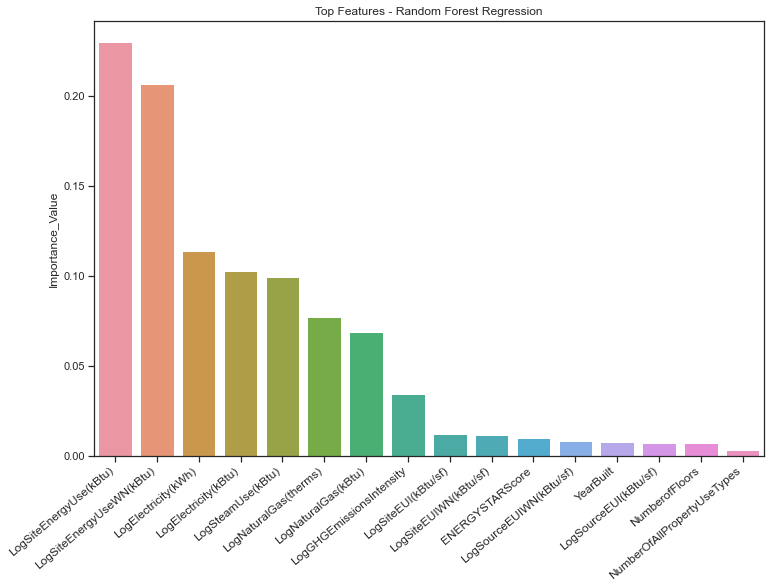

In [41]:
selectedFeaturesRFCO2 = selected_features_rf(X_trainCO2, NumericFeaturesCO2, y_trainCO2, 0.005)

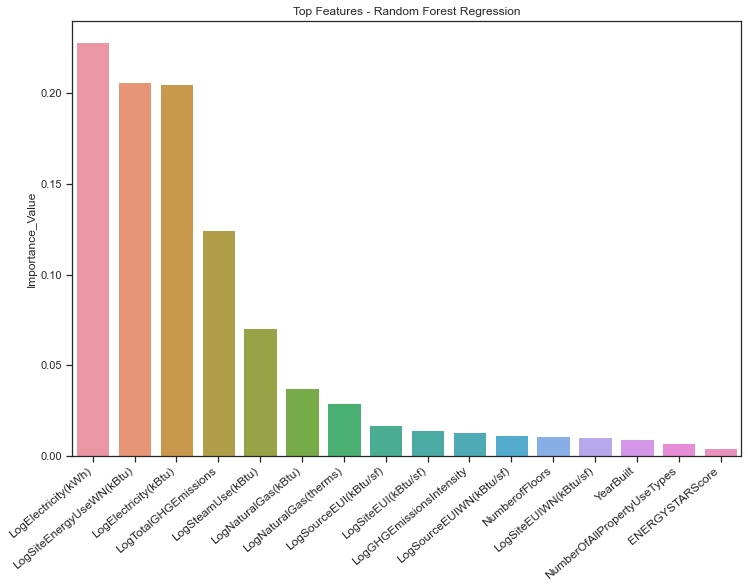

In [42]:
selectedFeaturesRFCTE = selected_features_rf(X_trainCTE, NumericFeaturesCTE, y_trainCTE, 0.005)

### Gradient Tree Boosting

In [43]:
def selected_features_gbr(data, NumericFeatures, target, threshold):
    data_continuous = data[NumericFeatures]
    gbr = GradientBoostingRegressor(loss='ls', n_estimators=200, learning_rate=0.1, 
                                max_depth=8, max_features = 'sqrt',  
                                min_samples_split = 500, random_state=0)
    gbr.fit(data_continuous, target.values.flatten())
    # Store the top most important features based off rf regressor
    gbr_feature_importance_df = pd.DataFrame(gbr.feature_importances_, index=NumericFeatures, columns=['Importance_Value'])
    gbr_top_features = gbr_feature_importance_df.sort_values(by = ['Importance_Value'], ascending=False)
    plt.figure(figsize = (12,8))
    ax = sns.barplot(x = gbr_top_features.index, y = 'Importance_Value', data=gbr_top_features)
    ax.set_xticklabels(ax.get_xticklabels(), fontsize = 12, rotation=40, ha="right")
    plt.title('Top Features - Gradient Tree Boosting Regression')
    plt.show()
    selectedFeaturesGBR = gbr_top_features[gbr_top_features.Importance_Value >= threshold].index.tolist()
    return selectedFeaturesGBR

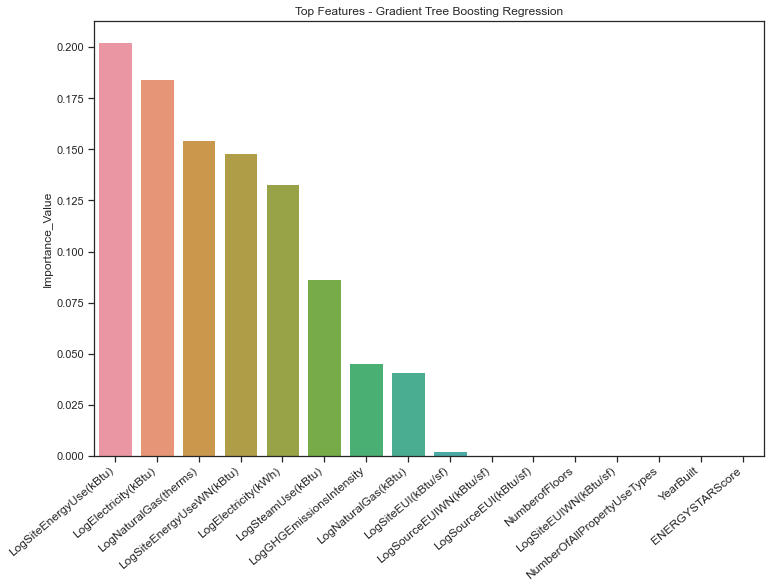

In [44]:
selectedFeaturesGBRCO2 = selected_features_gbr(X_trainCO2, NumericFeaturesCO2, y_trainCO2, 0.005)

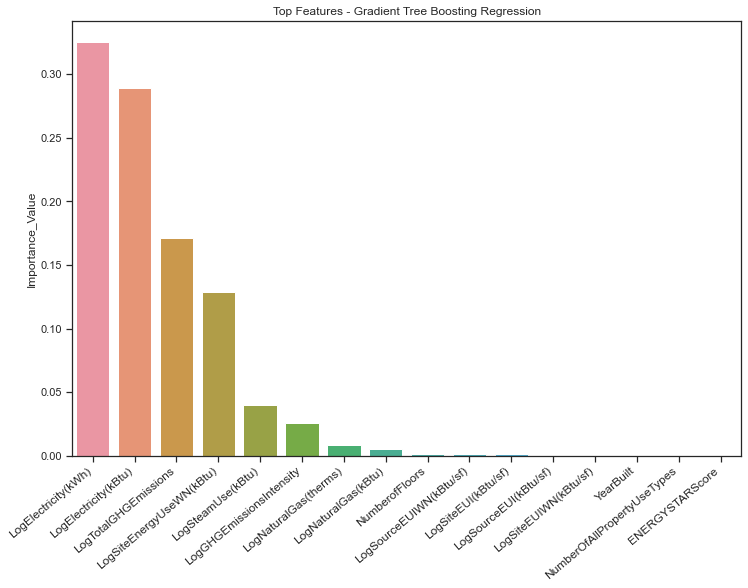

In [45]:
selectedFeaturesGBRCTE = selected_features_gbr(X_trainCTE, NumericFeaturesCTE, y_trainCTE, 0.005)

### Correlation analysis

In [46]:
def selected_features_cor(data, NumericFeatures):
    data_continuous = data[NumericFeatures]
    corr_matrix = data_continuous.corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    to_drop = [column for column in upper.columns if any(upper[column]>0.9)]
    selectedFeaturesCOR = [var for var in NumericFeatures if var not in to_drop]
    return selectedFeaturesCOR

In [47]:
selectedFeaturesCORCO2 = selected_features_cor(X_trainCO2, NumericFeaturesCO2)
selectedFeaturesCORCTE = selected_features_cor(X_trainCTE, NumericFeaturesCTE)

In [48]:
#### Let's merge all features selected from the Continuous section
selected_features_continuousCO2 = [var for var in NumericFeaturesCO2 if var in selectedFeaturesRFCO2 and
                                   var in selectedFeaturesLassoCO2 and var in selectedFeaturesGBRCO2 and
                                  var in selectedFeaturesCORCO2]

selected_features_continuousCTE = [var for var in NumericFeaturesCTE if var in selectedFeaturesRFCTE and
                                   var in selectedFeaturesLassoCTE and var in selectedFeaturesGBRCTE and
                                  var in selectedFeaturesCORCTE]

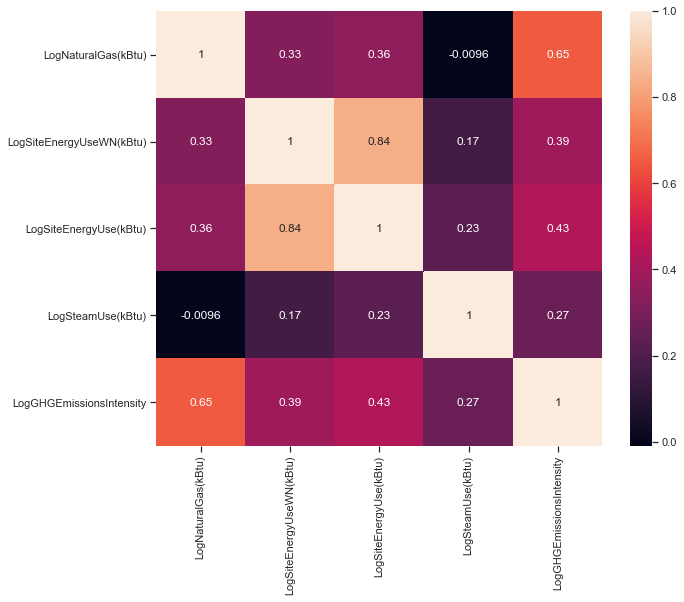

In [49]:
#Etudions la corrélation entre nos variables
corr_matrixCO2 = X_trainCO2[selected_features_continuousCO2].corr(method = 'pearson')
# Heatmap plot
plt.figure(figsize = (10,8))
sns.heatmap(corr_matrixCO2, annot = True)
plt.show()

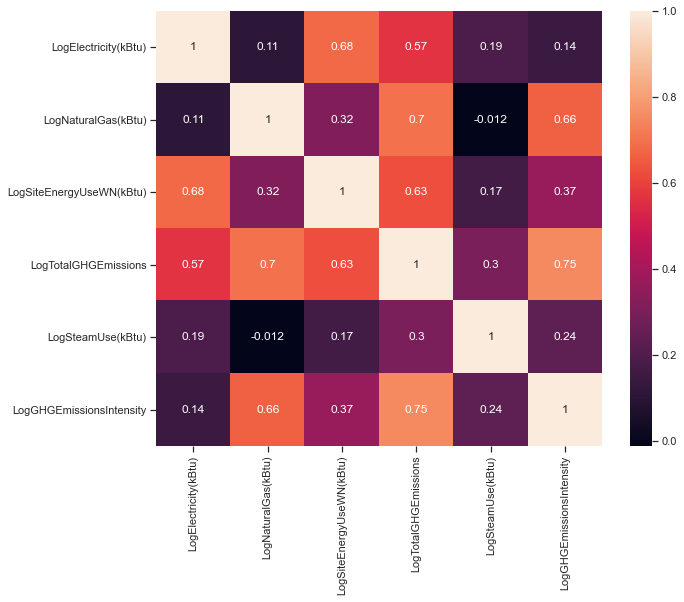

In [50]:
#Etudions la corrélation entre nos variables
corr_matrixCTE = X_trainCTE[selected_features_continuousCTE].corr(method = 'pearson')
# Heatmap plot
plt.figure(figsize = (10,8))
sns.heatmap(corr_matrixCTE, annot = True)
plt.show()

In [51]:
FeaturesCO2 = selectedFeaturesBinaryCO2 + selected_features_continuousCO2
FeaturesCTE = selectedFeaturesBinaryCTE + selected_features_continuousCTE

In [52]:
def features_selection(data, featuresToSelect):
    featuresToDrop = [var for var in data.columns if var not in featuresToSelect]
    data.drop(featuresToDrop, axis = 1, inplace = True)
    return data

In [53]:
X_trainCO2 = features_selection(X_trainCO2,FeaturesCO2)
X_trainCTE = features_selection(X_trainCTE,FeaturesCTE)

X_testCO2 = features_selection(X_testCO2,FeaturesCO2)
X_testCTE = features_selection(X_testCTE,FeaturesCTE)

In [54]:
FeaturesCO2 = [var for var in X_trainCO2.columns if var in X_testCO2.columns]
FeaturesCTE = [var for var in X_trainCTE.columns if var in X_testCTE.columns]

In [55]:
X_trainCO2 = X_trainCO2[FeaturesCO2]
X_trainCTE = X_trainCTE[FeaturesCTE]

X_testCO2 = X_testCO2[FeaturesCO2]
X_testCTE = X_testCTE[FeaturesCTE]

# Modeling

## Target Feature Transform

In [56]:
def target_transform(target):
    target_ = target.copy()
    target_ = np.log1p(target_)
    return target_

In [57]:
y_trainCO2_ = target_transform(y_trainCO2)
y_trainCTE_ = target_transform(y_trainCTE)

y_testCO2_ = target_transform(y_testCO2)
y_testCTE_ = target_transform(y_testCTE)

## The Models

In [58]:
## Naive Model
regNaive = DummyRegressor(strategy="mean")

## Linear Regression
regLR = LinearRegression()

## Ridge Regression
regRidge = Ridge(alpha = 0.005, max_iter = 500000, normalize = True)

## Lasso Regression
regLasso = Lasso(alpha = 0.005, max_iter = 500000, normalize = True)

## Elastic net Regression
regElasticNet = ElasticNet(l1_ratio=0.01, alpha=0.005, max_iter = 50000)

## SVR
regSVR = SVR(kernel = 'linear', max_iter = 500000)

## KNN Regression
regKNN = KNeighborsRegressor(n_neighbors = 5)

## Decision Tree
regDT = DecisionTreeRegressor(min_samples_leaf = 1, max_depth = 12)

## Bagging - ExtraTree Regression
regExtraTree = ExtraTreesRegressor(n_estimators=100, random_state=0)

## GradientBoosting Regression
regGradientBoosting = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='ls')

## Voting
regV1 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='ls')
regV2 = ExtraTreesRegressor(n_estimators=100, random_state=0)
regV3 = LinearRegression()
regVoting = VotingRegressor(estimators=[('gb', regV1), ('rf', regV2), ('lr', regV3)])

## Stacking
regS1 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0, loss='ls')
regS2 = ExtraTreesRegressor(n_estimators=100, random_state=0)
regS3 = LinearRegression()

estimators = [('GB', regS1), ('ETR', regS2), ('LR', regS3)]
regStacking = StackingRegressor(estimators=estimators, final_estimator=regS2)

In [59]:
def CompareModelPerformance(models, dataTrainSet, targetTrainSet, dataTestSet, targetTestSet):
    columns_names = [model.__class__.__name__ for model in models]
    ModelsPerf = pd.DataFrame(data = np.zeros((3,len(models))), 
                              index=['Average_RMSE', 'sd_RMSE', 'Generalization RMSE'], 
                              columns=columns_names)
    for counter, mod in enumerate(models):
        scores = -cross_val_score(mod, 
                                  dataTrainSet, 
                                  targetTrainSet.values.flatten(), 
                                  cv = 10, 
                                  scoring = 'neg_mean_squared_error')
        mod.fit(dataTrainSet, targetTrainSet.values.flatten())
        y_pred = mod.predict(dataTestSet)
        G_RMSE = np.sqrt(mean_squared_error(targetTestSet.values.flatten(),y_pred))
        ModelsPerf[columns_names[counter]].iloc[0] = np.sqrt(scores).mean()
        ModelsPerf[columns_names[counter]].iloc[1] = np.sqrt(np.sqrt(scores).var())
        ModelsPerf[columns_names[counter]].iloc[2] = G_RMSE
    return ModelsPerf

In [60]:
Models = [regNaive, regLR, regRidge, regLasso, regElasticNet, regSVR, regKNN, 
          regDT, regExtraTree, regGradientBoosting, regVoting, regStacking]


ModelPerformanceCO2 = CompareModelPerformance(Models, X_trainCO2, y_trainCO2_, X_testCO2, y_testCO2_)
ModelPerformanceCTE = CompareModelPerformance(Models, X_trainCTE, y_trainCTE_, X_testCTE, y_testCTE_)

In [61]:
ModelPerformanceCO2

,DummyRegressor,LinearRegression,Ridge,Lasso,ElasticNet,SVR,KNeighborsRegressor,DecisionTreeRegressor,ExtraTreesRegressor,GradientBoostingRegressor,VotingRegressor,StackingRegressor
Average_RMSE,1.451263,0.320297,0.320188,0.667190,0.320638,0.367415,0.276005,0.131343,0.080298,0.245844,0.169759,0.087454
sd_RMSE,0.190632,0.111426,0.111500,0.175457,0.114812,0.231833,0.059225,0.089386,0.062142,0.063262,0.069577,0.062821
Generalization RMSE,1.401291,0.339569,0.338658,0.676681,0.338735,0.471944,0.341540,0.206060,0.155916,0.251879,0.188959,0.158666


Le modèle final choisi pour la prédiction des émissions de CO2 est l'ExtraTreesRegressor car il présente la plus petite valeur de RMSE 

In [62]:
ModelPerformanceCTE

,DummyRegressor,LinearRegression,Ridge,Lasso,ElasticNet,SVR,KNeighborsRegressor,DecisionTreeRegressor,ExtraTreesRegressor,GradientBoostingRegressor,VotingRegressor,StackingRegressor
Average_RMSE,1.377195,0.480250,0.478827,0.621514,0.473549,0.622688,0.515970,0.477808,0.401540,0.446459,0.409912,0.383995
sd_RMSE,0.522837,0.367859,0.367221,0.414828,0.373581,0.472572,0.390597,0.579982,0.425827,0.409959,0.395271,0.459795
Generalization RMSE,1.187725,0.440122,0.437735,0.403655,0.432321,0.481930,0.258887,0.458446,0.267677,0.412008,0.344937,0.352075


Le modèle final choisi pour la prédiction de la consommation totale d’énergie est le StackingRegressor car il présente la plus petite valeur de RMSE

# END OF THE PROJECT

In [64]:
ModelPerformanceCO2.to_excel('D:/IML/project3/DATA/table1.xlsx')

In [65]:
ModelPerformanceCTE.to_excel('D:/IML/project3/DATA/table2.xlsx')